In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing Libraries
from tensorflow import keras
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from keras.utils import plot_model, model_to_dot
from keras.layers import Dense, Conv2D, Flatten, Dropout, Activation, MaxPooling2D, BatchNormalization

In [ ]:
keras.backend.set_image_data_format('channels_last')

Define weighted f1 and balanced accuarcy

In [ ]:
def evaluate(predicted_outcome, expected_outcome):
    from sklearn import metrics
    f1_score = metrics.f1_score(expected_outcome, predicted_outcome, average='weighted')
    balanced_accuracy_score = metrics.balanced_accuracy_score(expected_outcome, predicted_outcome)
    return f1_score, balanced_accuracy_score

Read data and split validation set

In [ ]:
# Data Preprocessing
def load_dataset_with_processing(input_train_test_fn, num_classes=10):
    data = np.load(input_train_test_fn)
    X_train, X_test, y_train, y_test = data['X_train'], data['X_test'], data['y_train'], data['y_test']

    # split validation set
    from sklearn.model_selection import train_test_split
    X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

    X_train = np.array(X_train, dtype="float") / 255.0
    X_train = X_train.reshape(X_train.shape[0], 28, 28,1 )
    print(X_train.shape)

    X_vali = np.array(X_vali, dtype="float") / 255.0
    X_vali = X_vali.reshape(X_vali.shape[0], 28, 28,1 )
    print(X_vali.shape)

    X_test = np.array(X_test, dtype="float") / 255.0
    X_test = X_test.reshape(X_test.shape[0], 28, 28,1 )
    print(X_test.shape)

    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_vali = keras.utils.to_categorical(y_vali, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    return X_train, y_train, X_vali, y_vali, X_test, y_test

Build a data generator

In [ ]:
# Creating a data generator for real-time data augmentation
def myGenerator(X_train, y_train, batch_size):
    total_size = X_train.shape[0]

    while True:
        permutation = list(np.random.permutation(total_size))
        for i in range(total_size//batch_size):
            index = permutation[i * batch_size : (i + 1) * batch_size]
            X_batch = X_train[index]
            y_batch = y_train[index]

            yield X_batch, y_batch

Build the lenet model with pretrained weights

In [ ]:
# Define Model
def build_model(input_shape, num_classes):
    # initialize the model
    model = Sequential()
    model.add(Conv2D(20, (5, 5), padding="same", input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))

    for layer in model.layers:
        layer.trainable = False  # freeze the previous layers

    X = model.output
    # softmax classifier
    predictions = Dense(10, activation='softmax')(X)
    old_model = Model(inputs=model.input, outputs=predictions)

    # load weights
    old_model.load_weights('/content/drive/MyDrive/pretrained_mnist/lenet.hdf5')

    X = model.output
    # softmax classifier
    predictions = Dense(num_classes, activation='softmax')(X)
    new_model = Model(inputs=model.input, outputs=predictions)
    plot_model(new_model, to_file='Model_LeNeT.png')
    new_model.summary()

    return new_model

input_shape = (28, 28, 1)
num_classes = 100
model = build_model(input_shape, num_classes)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8_input (InputLayer  [(None, 28, 28, 1)]       0         
 )                                                               
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 20)        520       
                                                                 
 activation_12 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 20)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 50)        25050     
                                                                 
 activation_13 (Activation)  (None, 14, 14, 50)        0   

*Define* the training function

In [ ]:
def train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs):
    import os
    if os.path.exists(checkpoint_dir) is False:
        os.makedirs(checkpoint_dir)

    model = build_model(input_shape, num_classes)

    checkpoint = ModelCheckpoint(checkpoint_dir + 'best_lenet.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)


    #Compile Keras Model
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)

    datagen = myGenerator(X_train, y_train, batch_size)

    history = model.fit(datagen,
                        steps_per_epoch = len(X_train) // batch_size,
                        epochs=epochs,
                        callbacks=[es, checkpoint],
                        verbose=2,
                        validation_data=(X_vali, y_vali))

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show()

    return model

Define the testing function

In [ ]:
def test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights):
    model = build_model(input_shape, num_classes)

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)

    # load weights
    model.load_weights(pretrained_weights)

    score = model.evaluate(X_test, y_test, verbose=0)

    testPredict = model.predict(X_test)
    y_test_tmp = np.argmax(y_test, axis=1)
    y_pred_tmp = np.argmax(testPredict, axis=1)
    f1_score, balanced_accuracy_score = evaluate(y_pred_tmp, y_test_tmp)

    return score[1], f1_score, balanced_accuracy_score  # return accuracies

Now we train the LeNet model

(395688, 28, 28, 1)
(98922, 28, 28, 1)
(107158, 28, 28, 1)
Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_18 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_27 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy did not improve from 0.94420
3091/3091 - 35s - loss: 0.8398 - accuracy: 0.9452 - val_loss: 1.0051 - val_accuracy: 0.9383 - 35s/epoch - 11ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.94420 to 0.95047, saving model to ./LeNet_MNIST_MIX/best.hdf5
3091/3091 - 35s - loss: 0.8094 - accuracy: 0.9508 - val_loss: 0.9285 - val_accuracy: 0.9505 - 35s/epoch - 11ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.95047
3091/3091 - 35s - loss: 0.7743 - accuracy: 0.9541 - val_loss: 1.0249 - val_accuracy: 0.9483 - 35s/epoch - 11ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.95047 to 0.95141, saving model to ./LeNet_MNIST_MIX/best.hdf5
3091/3091 - 35s - loss: 0.7531 - accuracy: 0.9571 - val_loss: 1.0248 - val_accuracy: 0.9514 - 35s/epoch - 11ms/step
Epoch 6/10

Epoch 6: val_accuracy improved from 0.95141 to 0.95451, saving model to ./LeNet_MNIST_MIX/best.hdf5
3091/3091 - 35s - loss: 0.7333 - accuracy: 0.9594 - val_loss: 1.0029 - val_accuracy: 

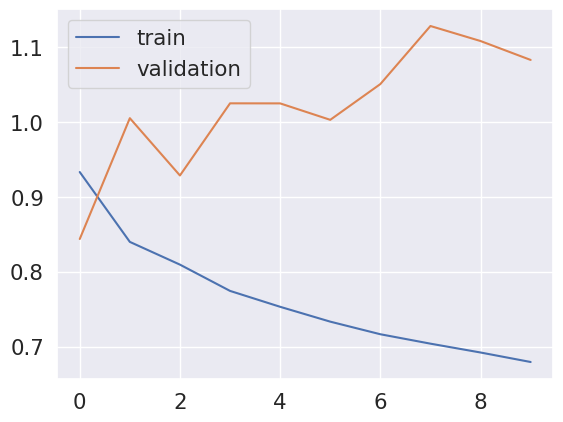

In [ ]:
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './LeNet_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/MNIST_MIX_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

Then we test the saved model

In [ ]:
pretrained_weights = './LeNet_MNIST_MIX/best_lenet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_20 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_30 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 
 activation_31 (Activation)  (None, 14, 14, 50)        0  

Plot the confusion matrix for different languages

In [ ]:
languages = ['Arabic', 'Bangla', 'Devanagari', 'English', 'Farsi', 'Kannada', 'Swedish', 'Telugu', 'Tibetan', 'Urdu']

In [ ]:
label = 0
idx = 0
labels = []
images = []
while label < 100:
    if y_train[idx] == label:
        labels.append(label)
        images.append(X_train[idx])
        label = label + 1
    idx = idx + 1
num_col = 10
num_row = 10
fig, axes = plt.subplots(num_col, num_row, figsize=(1.5*num_col,2*num_row))
for i in range(100):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title("%s in %s" %(labels[i]%10,languages[int(labels[i]/10)]))
plt.tight_layout()
plt.show()

In [ ]:
model = build_model(input_shape, num_classes)

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)

# load weights
model.load_weights(pretrained_weights)

testPredict = model.predict(X_test)

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_24 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_36 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 
 activation_37 (Activation)  (None, 14, 14, 50)        0  

In [ ]:
y_test_tmp = np.floor(np.argmax(y_test, axis=1) / 10).astype(int)
y_pred_tmp = np.floor(np.argmax(testPredict, axis=1) / 10).astype(int)

In [ ]:
label_mapping = {i:languages[i] for i in range(10)}
label_mapping

{0: 'Arabic',
 1: 'Bangla',
 2: 'Devanagari',
 3: 'English',
 4: 'Farsi',
 5: 'Kannada',
 6: 'Swedish',
 7: 'Telugu',
 8: 'Tibetan',
 9: 'Urdu'}

In [ ]:
y_true = [label_mapping[i] for i in y_test_tmp]
y_pred = [label_mapping[i] for i in y_pred_tmp]

In [ ]:
y_true[:10]

['Arabic',
 'Arabic',
 'Arabic',
 'Arabic',
 'Arabic',
 'Arabic',
 'Arabic',
 'Arabic',
 'Arabic',
 'Arabic']

In [ ]:
y_pred[:10]

['Urdu',
 'Arabic',
 'Arabic',
 'Arabic',
 'Bangla',
 'Arabic',
 'Urdu',
 'Farsi',
 'Farsi',
 'Arabic']

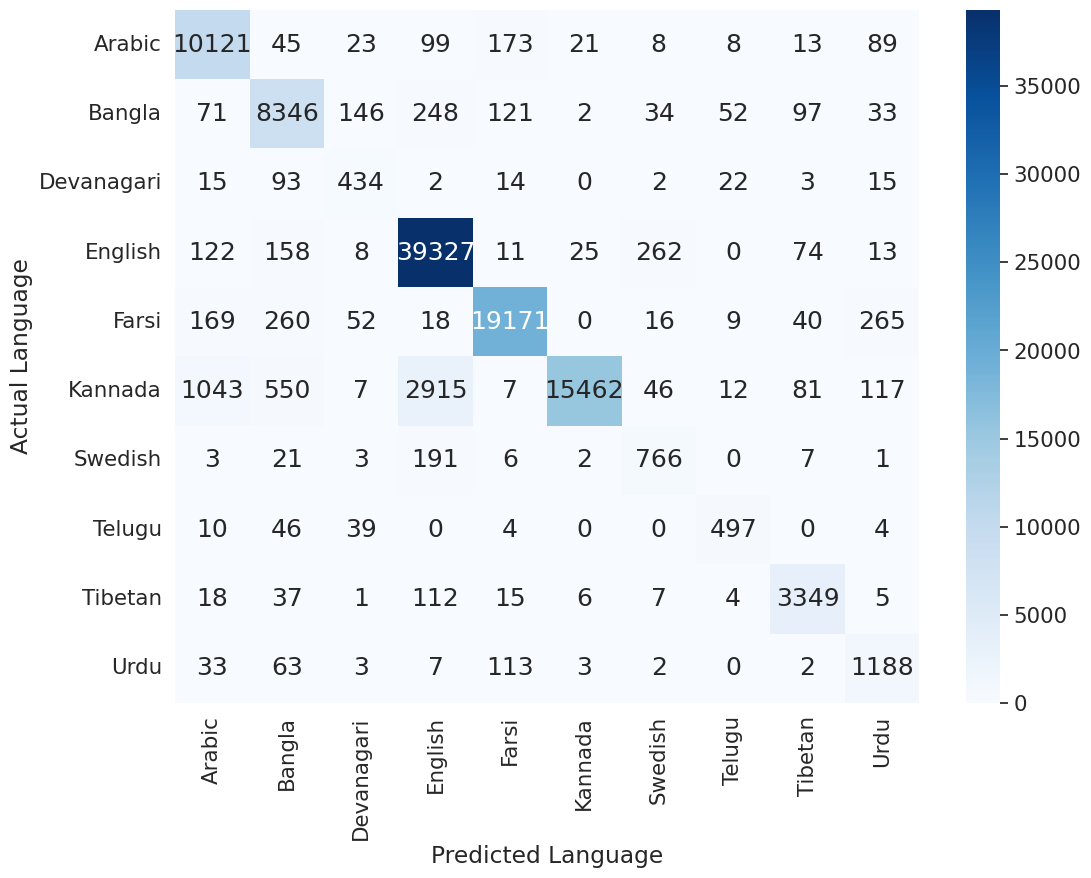

In [ ]:
# Confusion matrix for languages
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual Language'
df_cm.columns.name = 'Predicted Language'
plt.figure(figsize = (12, 9))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 18})  # font size
plt.savefig('languages-confusion-matrix.pdf', dpi=400, bbox_inches='tight')

Plot the confusion matrix for different numbers

In [ ]:
y_test_tmp = np.floor(np.argmax(y_test, axis=1) % 10).astype(int)
y_pred_tmp = np.floor(np.argmax(testPredict, axis=1) % 10).astype(int)

In [ ]:
label_mapping = {i:str(i) for i in range(10)}
label_mapping

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9'}

In [ ]:
y_true = [label_mapping[i] for i in y_test_tmp]
y_pred = [label_mapping[i] for i in y_pred_tmp]

In [ ]:
y_true[:10]

['6', '5', '4', '5', '5', '2', '8', '0', '1', '4']

In [ ]:
y_pred[:10]

['1', '5', '4', '5', '0', '2', '8', '0', '1', '4']

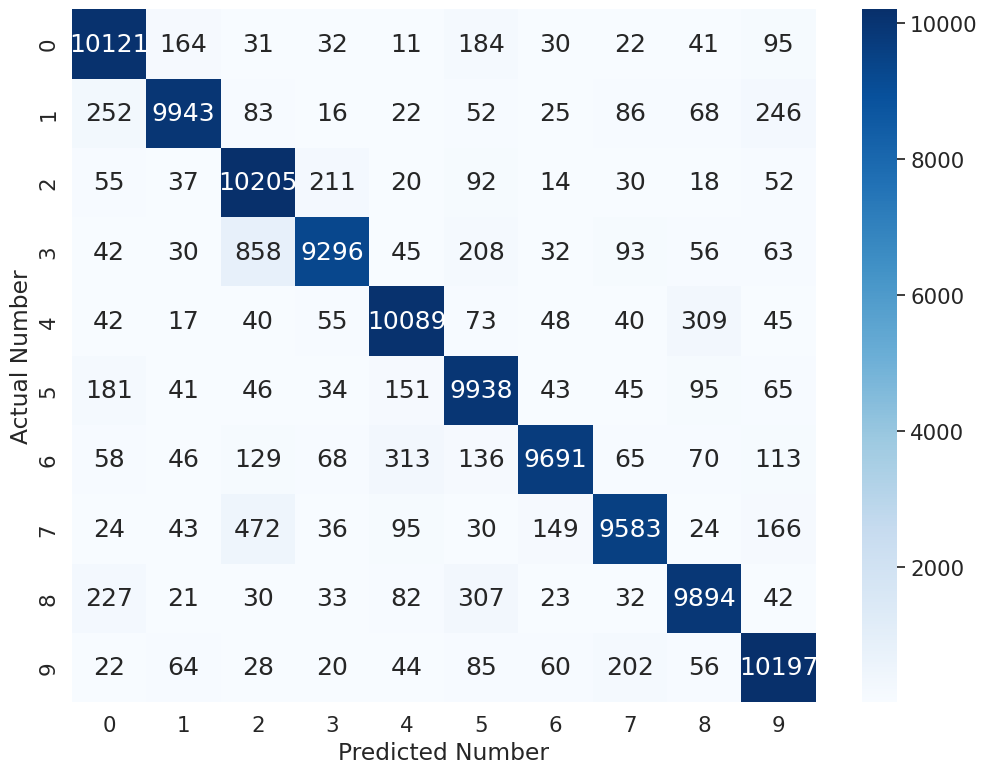

In [ ]:
# Confusion matrix for numbers[0-9]
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual Number'
df_cm.columns.name = 'Predicted Number'
plt.figure(figsize = (12, 9))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 18})  # font size
plt.savefig('numbers-confusion-matrix.pdf', dpi=400, bbox_inches='tight')

Some further exploration

In [ ]:
y_true = np.argmax(y_test, axis=1).astype(int)
y_pred = np.argmax(testPredict, axis=1).astype(int)

We can compare the confusion matrix between two numbers from one/two languages

In [ ]:
def plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred):
    index1 = languages.index(language1) * 10 + number1
    index2 = languages.index(language2) * 10 + number2
    pairs = [(i, j) for i, j in zip(y_true, y_pred) if i in (index1, index2) and j in (index1, index2)]
    y_true_tmp, y_pred_tmp = zip(*pairs)

    label_mapping = {index1: language1 + ': ' + str(number1),
                     index2: language2 + ': ' + str(number2)}

    y_true = [label_mapping[i] for i in y_true_tmp]
    y_pred = [label_mapping[i] for i in y_pred_tmp]


    data = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(data, columns=np.unique(y_true), index=np.unique(y_true))
    df_cm.index.name = 'Actual Number'
    df_cm.columns.name = 'Predicted Number'
    plt.figure(figsize = (12, 9))
    sn.set(font_scale=1.4)  # for label size
    sn.heatmap(df_cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 18})  # font size
    plt.savefig('%s-%s-%s-%s-confusion-matrix.pdf' % (language1, number1, language2, number2), dpi=400, bbox_inches='tight')

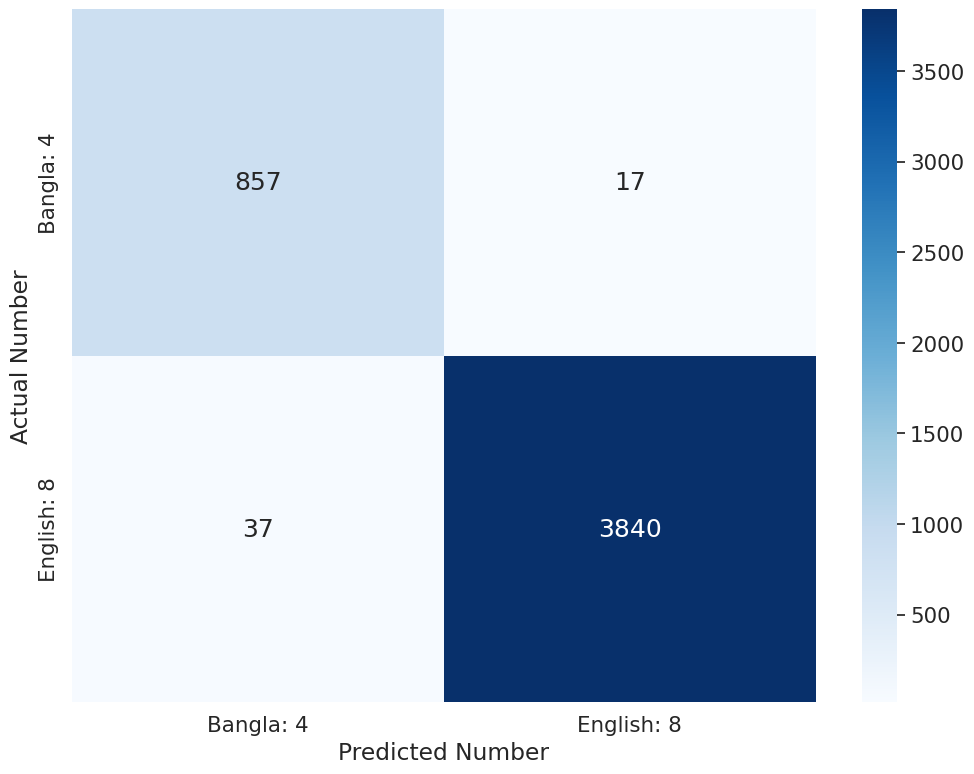

In [ ]:
number1 = 4
language1 = 'Bangla'
number2 = 8
language2 = 'English'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

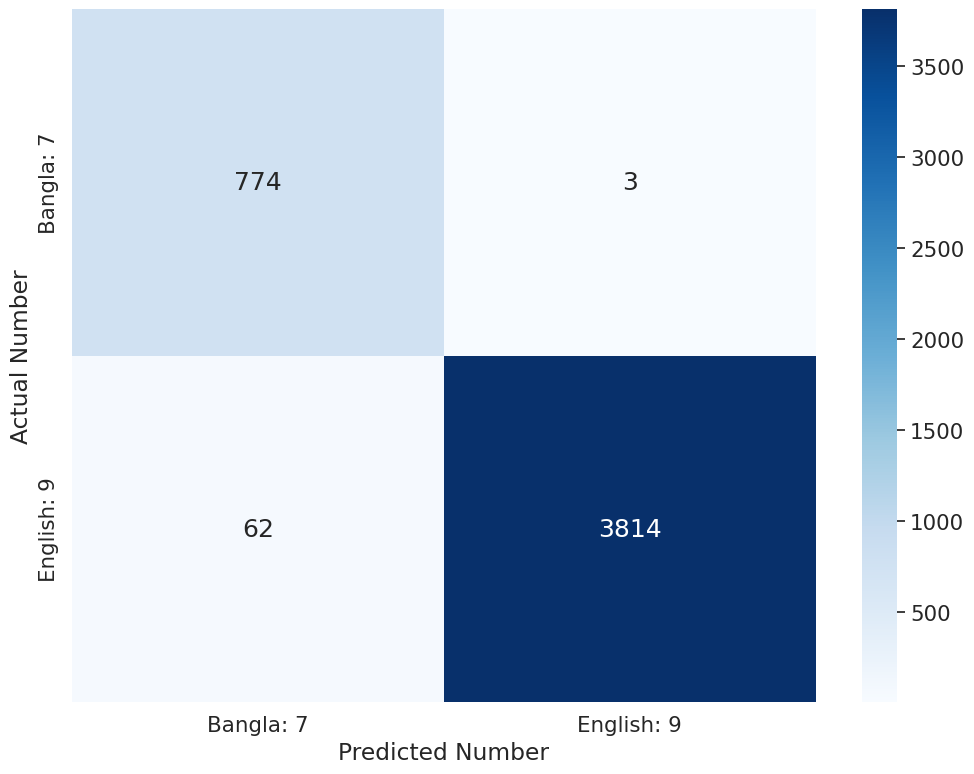

In [ ]:
number1 = 7
language1 = 'Bangla'
number2 = 9
language2 = 'English'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

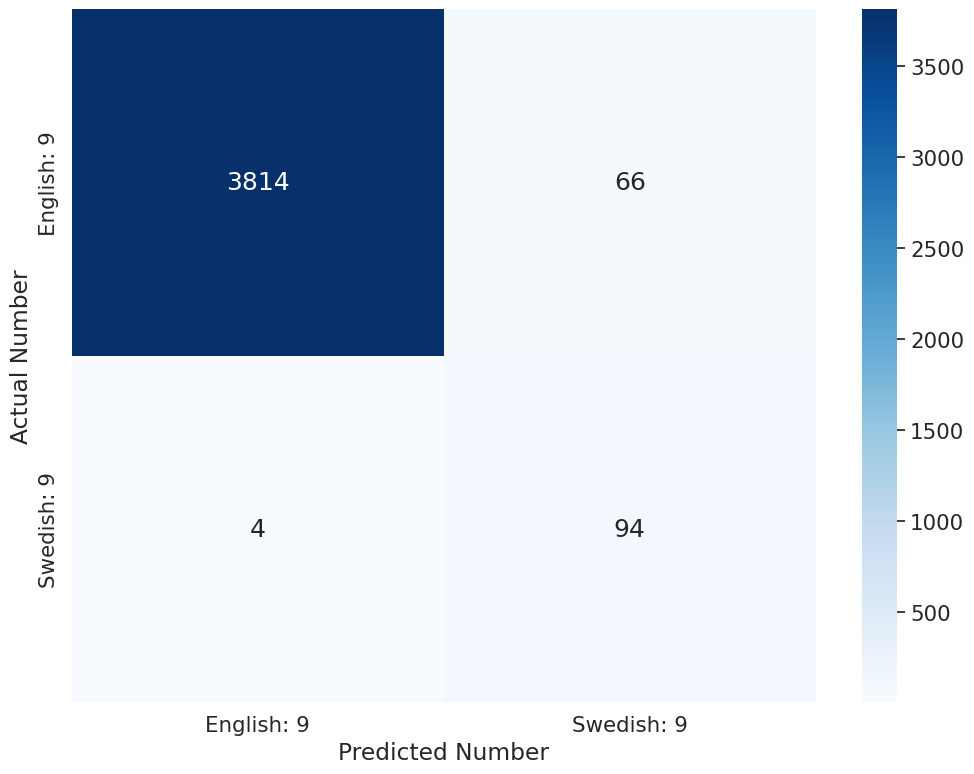

In [ ]:
number1 = 9
language1 = 'Swedish'
number2 = 9
language2 = 'English'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

Finding out which number pairs are the most difficult to distinguish:

In [ ]:
from sklearn import metrics
def pair_comparison(number1, language1, number2, language2, languages, full_cm):
    index1 = languages.index(language1) * 10 + number1
    index2 = languages.index(language2) * 10 + number2

    tmp_cm = full_cm[[index1, index2], :][:, [index1, index2]]

    accuracy = sum(np.diag(tmp_cm)) / sum(tmp_cm.flatten())
    return number1, language1, number2, language2, accuracy

In [ ]:
number1 = 9
language1 = 'Swedish'
number2 = 9
language2 = 'English'
full_cm = confusion_matrix(y_true, y_pred)
print(pair_comparison(number1, language1, number2, language2, languages, full_cm))

(9, 'Swedish', 9, 'English', 0.9824032176973353)


In [ ]:
results = []
# calculate full confusion matrix
full_cm = confusion_matrix(y_true, y_pred)
for i1 in range(len(languages)):
    for i2 in range(i1, len(languages)):
        language1 = languages[i1]
        language2 = languages[i2]
        for number1 in range(10):
            for number2 in range(number1, 10):
                if language1 == language2 and number1 == number2:
                    continue
                results.append(pair_comparison(number1, language1, number2, language2, languages, full_cm))
results = sorted(results, key=lambda x:x[-1])

In [ ]:
results[:10]

[(4, 'Devanagari', 4, 'Telugu', 0.7619047619047619),
 (2, 'English', 3, 'Kannada', 0.8747057758464603),
 (0, 'Devanagari', 0, 'Telugu', 0.8876404494382022),
 (4, 'Arabic', 6, 'Kannada', 0.8969601263324122),
 (0, 'English', 0, 'Kannada', 0.9020141535111595),
 (1, 'Bangla', 9, 'Bangla', 0.9254694835680751),
 (2, 'English', 7, 'Kannada', 0.9269037356321839),
 (2, 'Bangla', 2, 'Devanagari', 0.9370546318289786),
 (3, 'Kannada', 5, 'Kannada', 0.9422459893048128),
 (6, 'Kannada', 7, 'Kannada', 0.9430403621274991)]

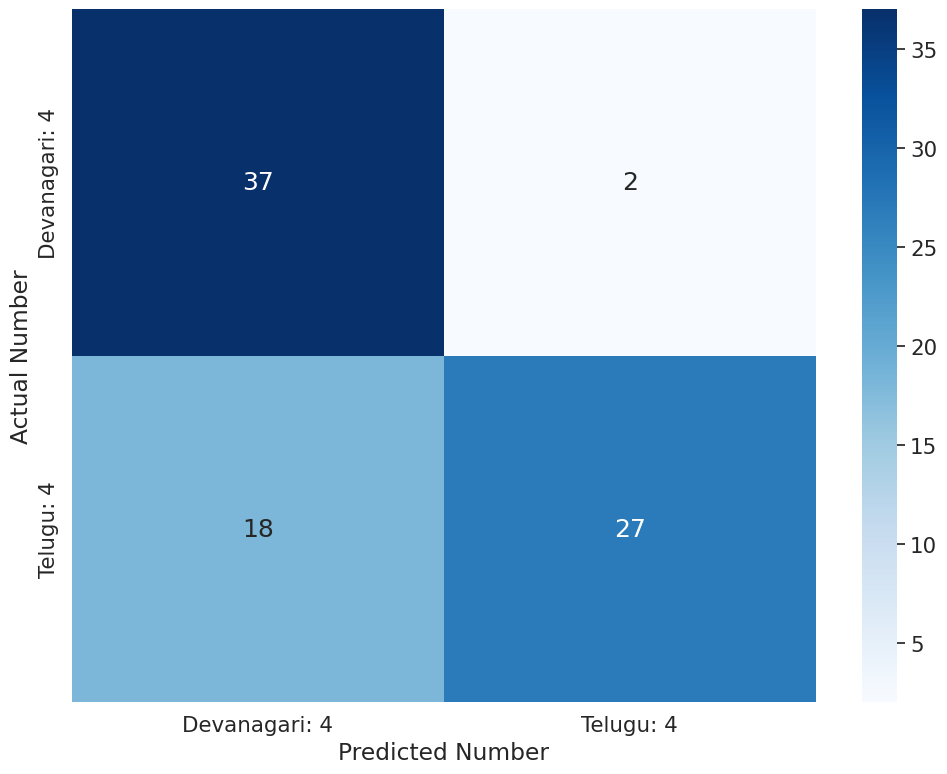

In [ ]:
number1 = 4
language1 = 'Devanagari'
number2 = 4
language2 = 'Telugu'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

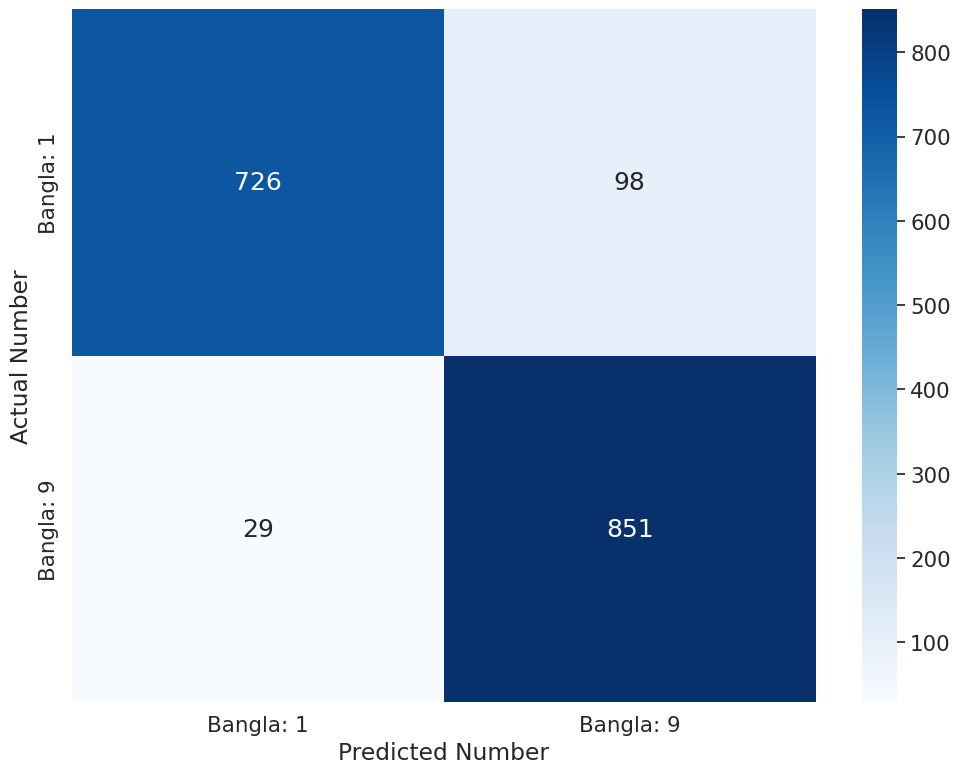

In [ ]:
number1 = 1
language1 = 'Bangla'
number2 = 9
language2 = 'Bangla'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

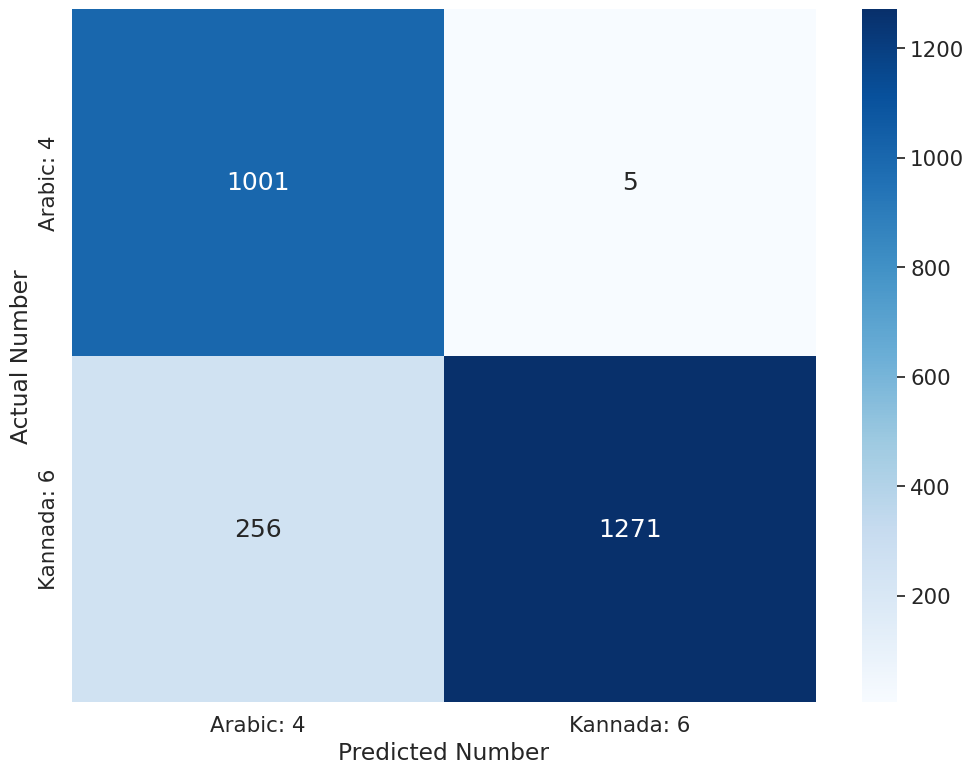

In [ ]:
number1 = 4
language1 = 'Arabic'
number2 = 6
language2 = 'Kannada'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

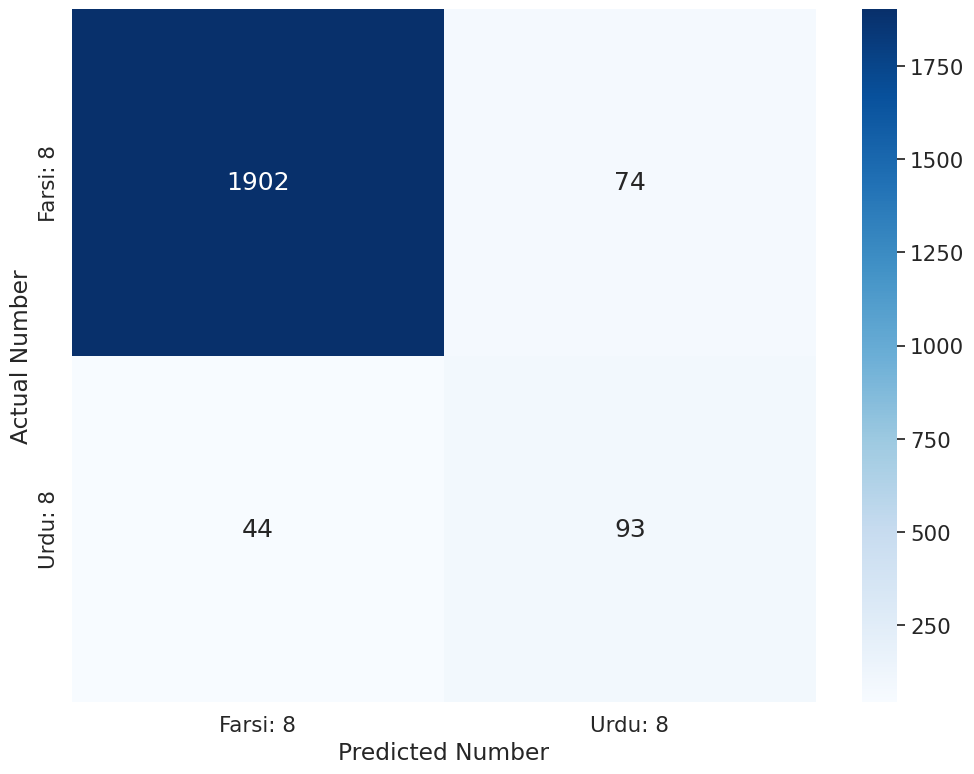

In [ ]:
number1 = 8
language1 = 'Farsi'
number2 = 8
language2 = 'Urdu'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

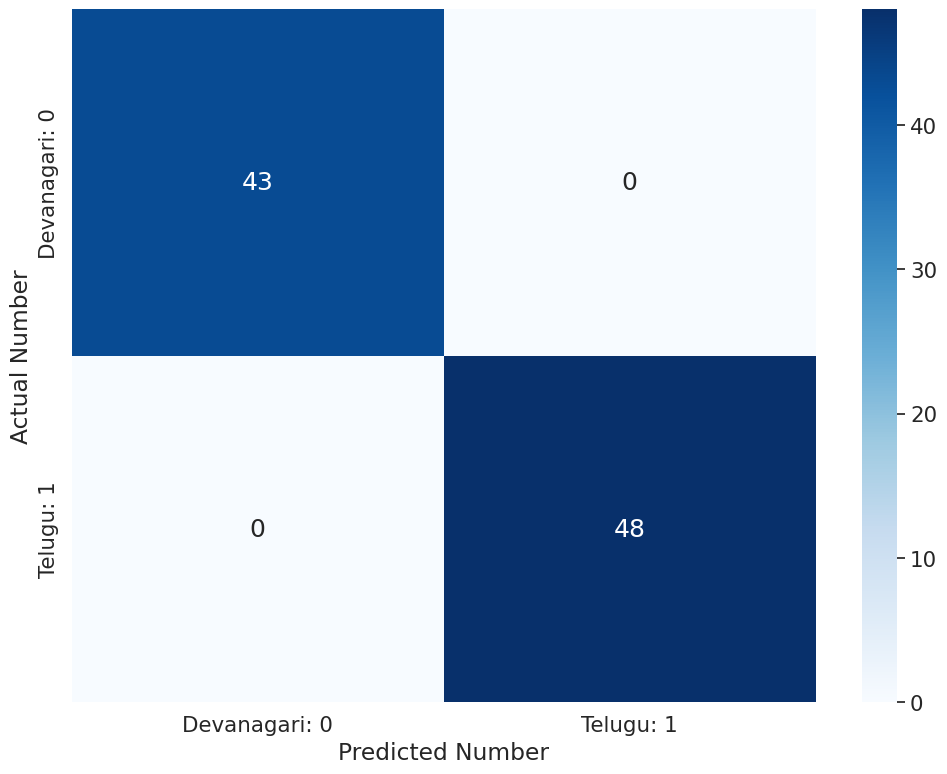

In [ ]:
number1 = 0
language1 = 'Devanagari'
number2 = 1
language2 = 'Telugu'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

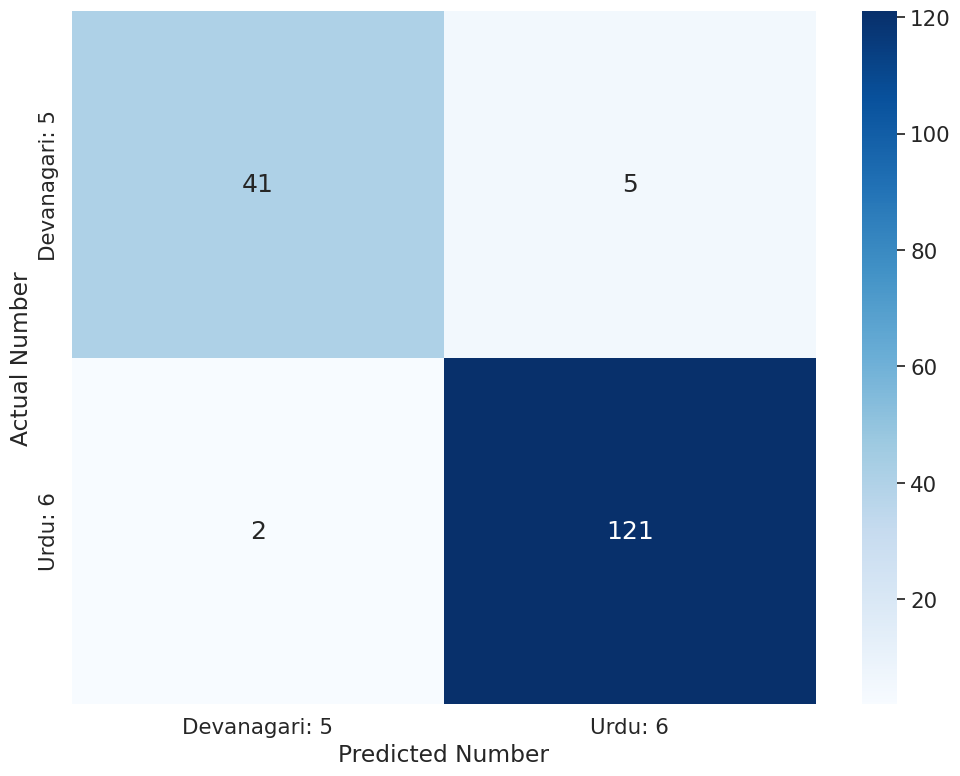

In [ ]:
number1 = 5
language1 = 'Devanagari'
number2 = 6
language2 = 'Urdu'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

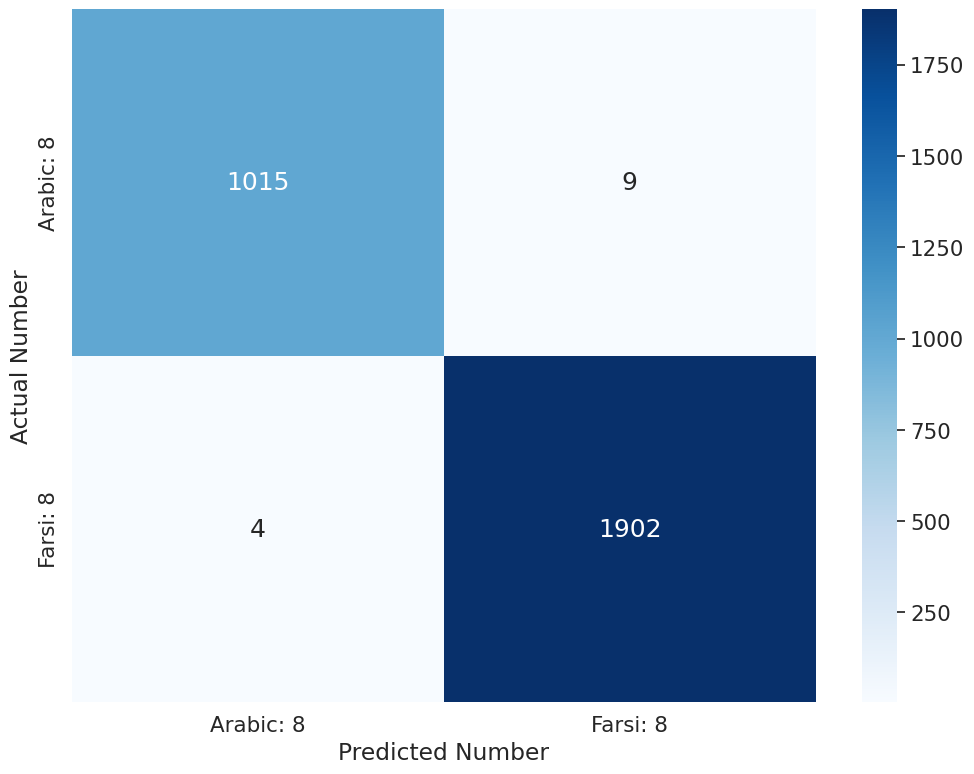

In [ ]:
number1 = 8
language1 = 'Arabic'
number2 = 8
language2 = 'Farsi'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

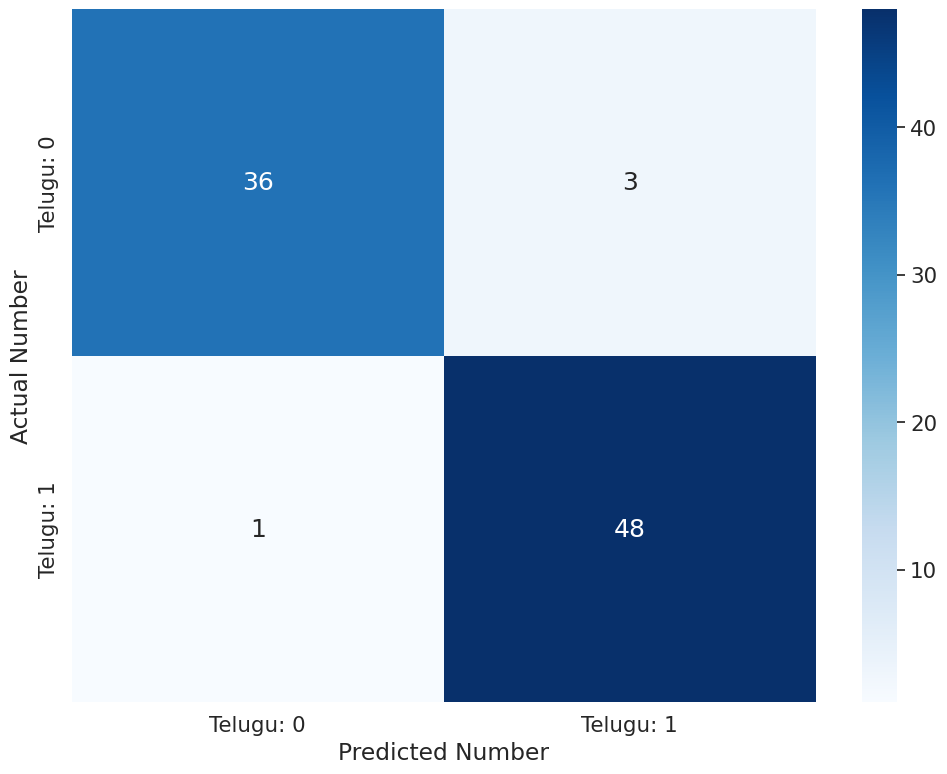

In [ ]:
number1 = 0
language1 = 'Telugu'
number2 = 1
language2 = 'Telugu'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

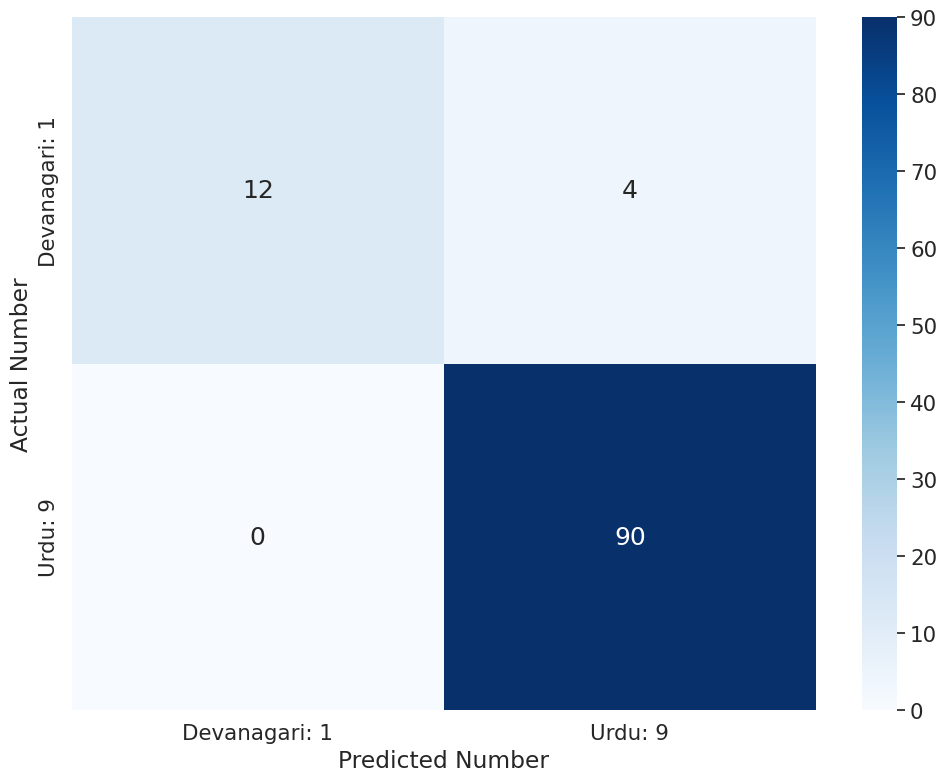

In [ ]:
number1 = 1
language1 = 'Devanagari'
number2 = 9
language2 = 'Urdu'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

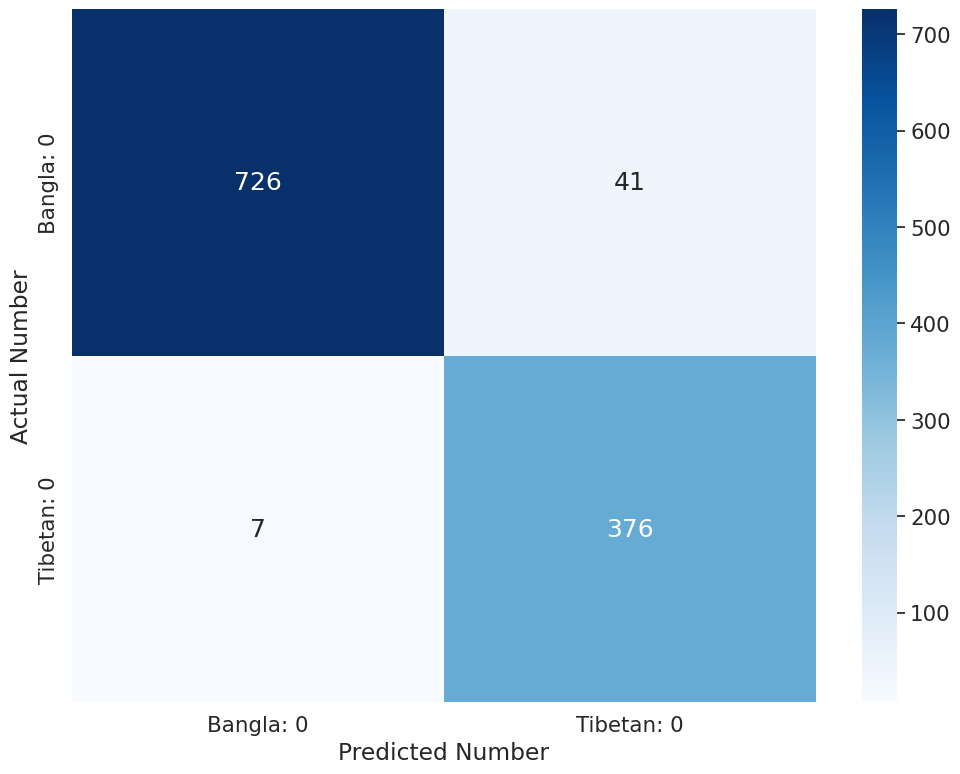

In [ ]:
number1 = 0
language1 = 'Bangla'
number2 = 0
language2 = 'Tibetan'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

Finally we want to make a visualization of these pairs:

In [ ]:
# we get the images from the training set
def get_image_to_plot(input_train_test_fn, pairs):
    image_to_plot_line1 = []
    image_to_plot_line2 = []

    data = np.load(input_train_test_fn)
    X_train, X_test, y_train, y_test = data['X_train'], data['X_test'], data['y_train'], data['y_test']

    for pair in pairs:
        number1, language1, number2, language2, _ = pair
        index1 = languages.index(language1) * 10 + number1
        index2 = languages.index(language2) * 10 + number2

        # find two images to plot

        for (i, j) in zip(X_train, y_train):
            if j == index1:
                image_to_plot_line1.append(i)
                break
        for (i, j) in zip(X_train, y_train):
            if j == index2:
                image_to_plot_line2.append(i)
                break
    return [image_to_plot_line1, image_to_plot_line2]

In [ ]:
pairs = results[:10]
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/MNIST_MIX_train_test.npz'
image_to_plot = get_image_to_plot(input_train_test_fn, pairs)
len(image_to_plot[0])

10

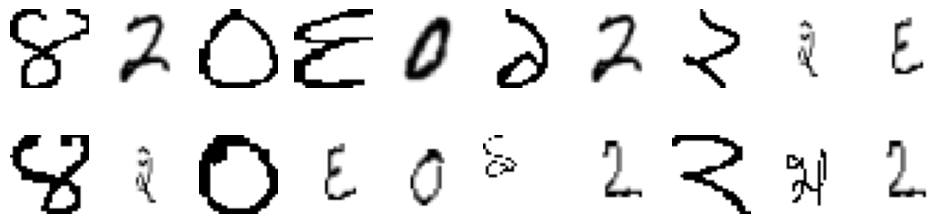

In [ ]:
fig, axes = plt.subplots(2, 10, figsize=[12, 3])
# plt.subplots_adjust(wspace=0, hspace=0)
for i in range(2):
    for j in range(10):
        axes[i, j].imshow(255 - image_to_plot[i][j], cmap=plt.cm.gray)
        axes[i, j].axis('off')
plt.savefig('difficult_pairs.pdf', dpi=400, bbox_inches='tight')